---
## 1. PRE-PROCESSING THE DATA

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Your code goes here for this section.
import pandas as pd
import numpy as np

#data = pd.read_csv('US_Accidents_March23.csv')
#columns_to_read = ['Source', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'State']
columns_to_read = ['Severity', 'Start_Lat', 'Start_Lng', 'State', 'Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)']
data = pd.read_csv('drive/My Drive/Colab Notebooks/US_Accidents_March23.csv', usecols=columns_to_read)
data.head(10)

,Severity,Start_Lat,Start_Lng,State,Temperature(F),Visibility(mi)
0,3,39.865147,-84.058723,OH,36.9,10.0
1,2,39.928059,-82.831184,OH,37.9,10.0
2,2,39.063148,-84.032608,OH,36.0,10.0
3,3,39.747753,-84.205582,OH,35.1,9.0
4,2,39.627781,-84.188354,OH,36.0,6.0
5,3,40.100590,-82.925194,OH,37.9,7.0
6,2,39.758274,-84.230507,OH,34.0,7.0
7,3,39.770382,-84.194901,OH,34.0,7.0
8,2,39.778061,-84.172005,OH,33.3,5.0
9,3,40.100590,-82.925194,OH,37.4,3.0


In [4]:
mask = data['State'] == 'VA'
data = data[mask]
del data['State']
data.head(3)

,Severity,Start_Lat,Start_Lng,Temperature(F),Visibility(mi)
228559,3,38.815727,-77.138252,64.0,10.0
228563,3,38.954506,-77.193832,64.0,10.0
228584,3,39.217541,-78.137474,53.6,4.0


In [37]:
sample_incomplete_rows = data[data.isnull().any(axis=1)].head()
data = data.dropna()
sample_incomplete_rows

,Severity,Start_Lat,Start_Lng,Temperature(F),Visibility(mi)
229981,3,38.826393,-77.457069,NaN,10.0
230446,2,38.791416,-77.629707,NaN,NaN
230455,2,38.830524,-77.412788,NaN,10.0
230462,2,38.757526,-77.577782,NaN,10.0
230661,2,38.795879,-77.613365,NaN,10.0


<Axes: xlabel='Start_Lng', ylabel='Start_Lat'>

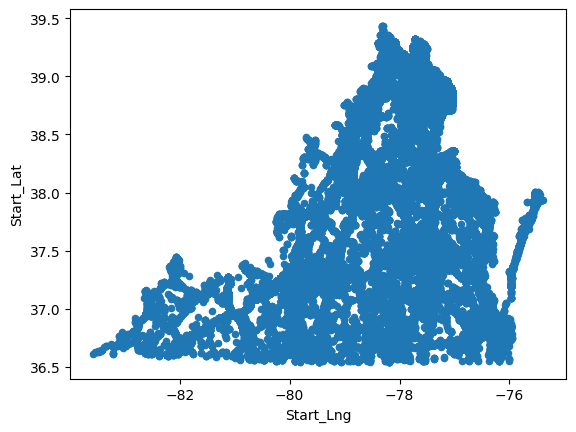

In [ ]:
data.plot(kind="scatter", x="Start_Lng", y="Start_Lat")

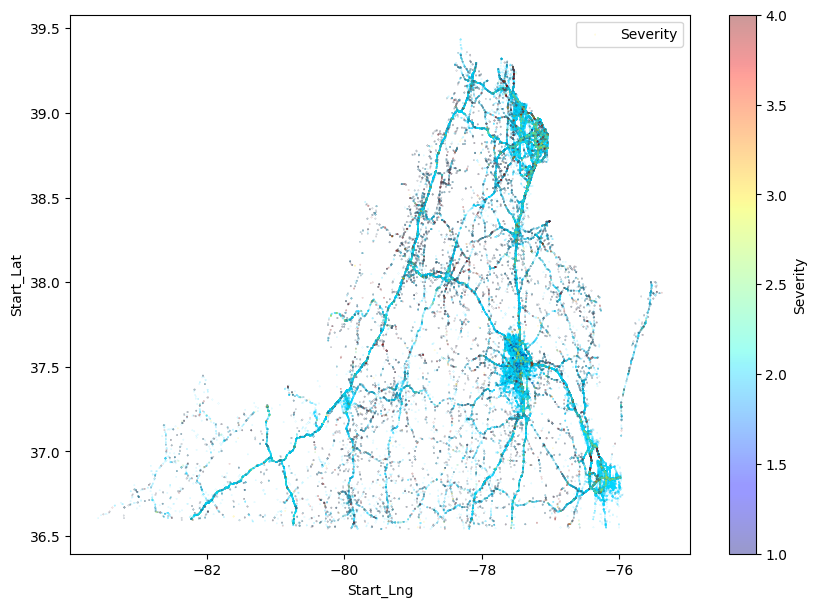

In [ ]:
import matplotlib.pyplot as plt

data.plot(kind="scatter", x="Start_Lng", y="Start_Lat", alpha=0.4,
    s=data["Severity"]/100, label="Severity", figsize=(10,7),
    c="Severity", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [44]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

X_train = [];
y_train = [];
X_test = [];
y_test = [];

X_train, X_test, y_train, y_test = train_test_split(data, data['Severity'], test_size=0.20, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(data, data['Temperature(F)'], test_size=0.99, random_state=42)
corr_matrix = X_train.corr()
corr_matrix.shape

(5, 5)

In [7]:
corr_matrix["Severity"].sort_values(ascending=False)

Severity          1.000000
Start_Lat        -0.011177
Temperature(F)   -0.014358
Visibility(mi)   -0.029000
Start_Lng        -0.057765
Name: Severity, dtype: float64

In [45]:
X_train.drop("Severity", axis=1)
#X_train.drop("Temperature(F)", axis=1)

,Start_Lat,Start_Lng,Temperature(F),Visibility(mi)
6024095,36.914062,-76.416197,71.0,10.0
4895845,38.839512,-77.086415,64.0,10.0
6346234,37.113385,-79.952118,39.0,10.0
4635890,37.548209,-77.563211,76.0,10.0
4419050,38.966770,-77.355686,31.0,10.0
...,...,...,...,...
4084671,37.376855,-77.414211,57.0,10.0
6829717,38.877758,-77.270253,51.0,10.0
4303533,38.793272,-77.050177,50.0,10.0
4569416,38.743390,-77.188298,61.0,10.0


In [46]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

data_num = data.select_dtypes(include=[np.number])
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('std_scaler', StandardScaler()),
        ('std_scaler', StandardScaler()),
    ])

data_num_tr = num_pipeline.fit_transform(data_num)

cat = ['ocean_proximity']
data_cat = pd.DataFrame(data, columns=cat)

num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        #("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
        #("cat", OneHotEncoder(), cat_attribs),
    ])

X_train = full_pipeline.fit_transform(X_train)
X_train.shape

(227845, 5)

---
## 2. Model Selection

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [2.31534045e-15 2.35454977e-15 2.90639644e-15 1.51409249e-15
 2.21613512e-15]
Mean: 2.261302855524487e-15
Standard deviation: 4.445501633436428e-16


In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [0. 0. 0. 0. 0.]
Mean: 0.0
Standard deviation: 0.0


In [49]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [0. 0. 0. 0. 0.]
Mean: 0.0
Standard deviation: 0.0
